In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from AWNN import AWNN
from KNN import KNN 
from AKDE import AKDE
from sklearn.neighbors import KernelDensity

from synthetic_distributions import TestDistribution


## Geology Inference

In [5]:
log_file_dir="./dataset/earthquake"
log_file_name="query"
log = pd.read_csv("{}/{}.csv".format(log_file_dir,log_file_name))  
X_train=pd.DataFrame(log,columns=["longitude","latitude"]).to_numpy()

In [11]:
# generate grid
n_test=100
latitude_l,latitude_u=(X_train[:,0].min(),X_train[:,0].max())
longitude_l,longitude_u=(X_train[:,1].min(),X_train[:,1].max())

X_test_1=np.linspace(latitude_l,latitude_u,n_test)
X_test_2=np.linspace(longitude_l,longitude_u,n_test)
axis1,axis2=np.meshgrid(X_test_1,X_test_2)
X_test=np.array([axis1.ravel(),axis2.ravel()]).T


## produce estimation
# AWNN
model_AWNN=AWNN(C=0.5).fit(X_train)
est_AWNN=np.exp(model_AWNN.predict(X_test).reshape(-1,n_test))
# KNN
model_KNN=KNN(k=30).fit(X_train,method="BKNN")
est_KNN=np.exp(model_KNN.predict(X_test).reshape(-1,n_test))
# WKNN
model_WKNN=KNN(k=30).fit(X_train,method="WKNN")
est_WKNN=np.exp(model_WKNN.predict(X_test).reshape(-1,n_test))
# KDE
model_KDE=KernelDensity().fit(X_train)
est_KDE=np.exp(model_KDE.score_samples(X_test).reshape(-1,n_test))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

![avatar](./dataset/earthquake/seismic_rate.jpeg)

Text(0.5, 1.0, 'AWNN')

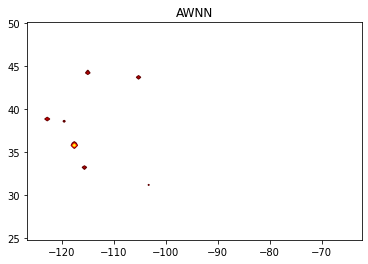

In [7]:
# plot AWNN contour

plt.contour(axis1, axis2,est_AWNN ,cmap=plt.cm.hot)
plt.title("AWNN")


Text(0.5, 1.0, 'KNN')

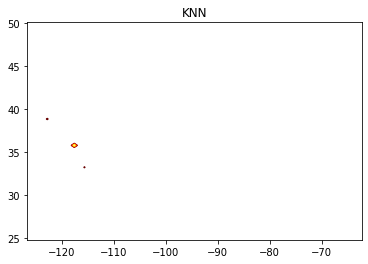

In [8]:
# plot KNN contour
plt.contour(axis1, axis2,est_KNN ,cmap=plt.cm.hot)
plt.title("KNN")


Text(0.5, 1.0, 'WKNN')

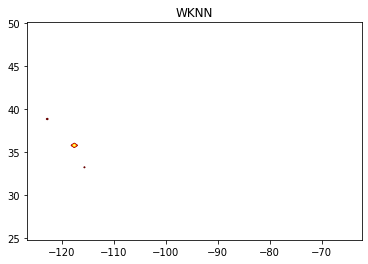

In [9]:
# plot WKNN contour
plt.contour(axis1, axis2,est_WKNN ,cmap=plt.cm.hot)
plt.title("WKNN")

Text(0.5, 1.0, 'KDE')

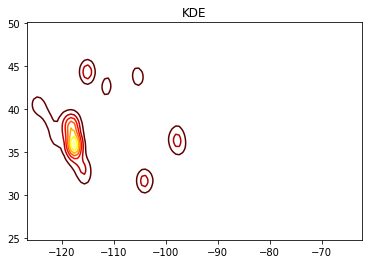

In [10]:
# plot KDE contour
plt.contour(axis1, axis2,est_KDE ,cmap=plt.cm.hot)
plt.title("KDE")

## Anomaly Detection

In [5]:

dim=8
n_train=1000
distribution=12
np.random.seed(2)
density=TestDistribution(distribution,dim).returnDistribution()

X_train, pdf_X_train = density.generate(n_train)

y_train=2*(pdf_X_train>np.median(pdf_X_train))-1


In [6]:
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [7]:
# isolation forest 
from sklearn.ensemble import IsolationForest
roc_auc=0
for n_estimators in [100,300,500]:
    model_IF=IsolationForest(random_state=1,n_estimators=n_estimators).fit(X_train,y_train)
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(model_IF.decision_function(X_train).reshape(-1,1))
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
    
roc_auc

0.9478199999999999

In [8]:
# Local outlier factor
from sklearn.neighbors import LocalOutlierFactor

roc_auc=0
for n_neighbors in [5*i for i in range(1,11)]:
    model_LOF=LocalOutlierFactor(n_neighbors=n_neighbors).fit(X_train,y_train)
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(model_LOF.negative_outlier_factor_.reshape(-1,1))
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))


roc_auc

0.949808

In [9]:
# One class svm
from sklearn.svm import OneClassSVM
roc_auc=0
for gamma in [1e-3,1e-2,1e-1,1,1e1]:
    model_OCSVM=OneClassSVM(gamma=gamma).fit(X_train,y_train)
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(model_OCSVM.decision_function(X_train).reshape(-1,1))
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))


roc_auc
    

0.9372879999999999

In [10]:
# KNN
from sklearn.neighbors import KDTree
roc_auc=0
tree_KNN=KDTree(X_train)
for n_neighbors in [5*i for i in range(1,11)]:
    distance_vec,_=tree_KNN.query(X_train,n_neighbors+1)
    distance_vec=distance_vec[:,-1]
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(-distance_vec.reshape(-1,1))
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))


roc_auc

0.9553420000000001

In [11]:
# AWNN
from AWNN import AWNN
roc_auc=0
for C in [i for i in np.logspace(-1,1,10)]:
    model_AWNN=AWNN(C=C).fit(X_train)
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(model_AWNN.predict(X_train).reshape(-1,1))
    #print(y_pred)
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
roc_auc

0.9560079999999999

In [12]:
import glob
import os

data_file_dir = "./dataset/anomly/"
method_seq = glob.glob("{}/*.csv".format(data_file_dir))
data_file_name_seq = [os.path.split(method)[1] for method in method_seq]
log_file_dir = "./anomly_result/"

In [25]:

def calculate_auc(X_train,y_train):
    
    roc_auc_vec=[]
    
    # IForest
    roc_auc=0
    for n_estimators in [100,300,500]:
        model_IF=IsolationForest(random_state=1,n_estimators=n_estimators).fit(X_train,y_train)
        scaler=MinMaxScaler()
        y_pred=scaler.fit_transform(model_IF.decision_function(X_train).reshape(-1,1))
        roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
    roc_auc_vec.append(roc_auc)
    
    # LOF
    roc_auc=0
    for n_neighbors in [5*i for i in range(1,11)]:
        model_LOF=LocalOutlierFactor(n_neighbors=n_neighbors).fit(X_train,y_train)
        scaler=MinMaxScaler()
        y_pred=scaler.fit_transform(model_LOF.negative_outlier_factor_.reshape(-1,1))
        roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
    roc_auc_vec.append(roc_auc)
    
    # OCSVM
    roc_auc=0
    for gamma in [1e-3,1e-2,1e-1,1,1e1]:
        model_OCSVM=OneClassSVM(gamma=gamma).fit(X_train,y_train)
        scaler=MinMaxScaler()
        y_pred=scaler.fit_transform(model_OCSVM.decision_function(X_train).reshape(-1,1))
        roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
    roc_auc_vec.append(roc_auc)

    # KNN
    roc_auc=0
    k_save=0
    tree_KNN=KDTree(X_train)
    for n_neighbors in [5*i for i in range(1,11)]:
        distance_vec,_=tree_KNN.query(X_train,n_neighbors+1)
        distance_vec=distance_vec[:,-1]
        scaler=MinMaxScaler()
        y_pred=scaler.fit_transform(-distance_vec.reshape(-1,1))
        roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
        if roc_auc_score(y_train,y_pred)==roc_auc:
            k_save=n_neighbors
    roc_auc_vec.append(roc_auc)

    # AWNN
    roc_auc=0
    C_save=0.001
    for C in [i for i in np.logspace(-3,2,30)]:
        model_AWNN=AWNN(C=C).fit(X_train,max_neighbors=X_train.shape[0]-1)
        scaler=MinMaxScaler()
        y_pred=scaler.fit_transform(model_AWNN.predict(X_train).reshape(-1,1))
        y_pred[y_pred==0]=1
        roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
        if roc_auc_score(y_train,y_pred)==roc_auc:
            C_save=C
            
    roc_auc_vec.append(roc_auc)
    print(C_save)
    print(k_save)
    
    return roc_auc_vec

In [16]:
for data_file_name in data_file_name_seq:
    data_file_path = os.path.join(data_file_dir, data_file_name)
    data = pd.read_csv(data_file_path)
    data = np.array(data)
    X_train=data[:,:-1]
    
    y_train=data[:,-1]
    y_train=1-2*y_train
    #print(calculate_auc(X_train,y_train))
    
    
    
    

In [27]:
from sklearn.decomposition import PCA
data_file_name_seq=["BreastW.csv","Lympho.csv","glass.csv"]
data_file_path=os.path.join(data_file_dir, "glass.csv")
data = pd.read_csv(data_file_path)
data = np.array(data)
X_train=data[:,:-1]


y_train=data[:,-1]
y_train=1-2*y_train
calculate_auc(X_train,y_train)

0.38566204211634725
10


[0.7184095860566448,
 0.8393246187363834,
 0.8758169934640522,
 0.8676470588235294,
 0.8785403050108933]

In [90]:
roc_auc=0
for C in [i for i in np.logspace(-3,2,20)]:
    model_AWNN=AWNN(C=C).fit(X_train)
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(model_AWNN.predict(X_train).reshape(-1,1))
    y_pred[y_pred==0]=1
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
    print(roc_auc_score(y_train,y_pred))

0.8988754448398576
0.8989181494661922
0.8990320284697508
0.8991316725978648
0.8995017793594307
0.9001138790035588
0.9018362989323844
0.90888256227758
0.9168540925266904
0.9430035587188613
0.9210533807829182
0.8091103202846975
0.7806548042704627
0.6796868327402135
0.5969252669039147
0.5243274021352313
0.5564982206405695
0.5267758007117438
0.5378291814946619
0.5448256227758007


In [62]:
data.shape

(3771, 7)

In [91]:
roc_auc=0
tree_KNN=KDTree(X_train)
for n_neighbors in [5*i for i in range(1,11)]:
    distance_vec,_=tree_KNN.query(X_train,n_neighbors+1)
    distance_vec=distance_vec[:,-1]
    scaler=MinMaxScaler()
    y_pred=scaler.fit_transform(-distance_vec.reshape(-1,1))
    roc_auc=max(roc_auc,roc_auc_score(y_train,y_pred))
    print(roc_auc_score(y_train,y_pred))


0.9748327402135232
0.9680000000000001
0.962661921708185
0.9590604982206405
0.9557580071174379
0.9520711743772242
0.9495800711743771
0.9489395017793593
0.9450960854092527
0.9434448398576512
